# Import images

In [1]:
import os
import shutil
import time
import pandas as pd
import numpy as np

import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
%matplotlib inline

In [3]:
train_filenames = os.listdir('./train/train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

In [4]:
test_filenames = os.listdir('./test/test')

In [5]:
len(train_filenames)

25000

In [6]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

In [70]:
# rmrf_mkdir('train2')
# os.mkdir('train2/cat')
# os.mkdir('train2/dog')

# rmrf_mkdir('test2')
# os.symlink('test/', 'test2/test')

# for filename in train_cat:
#     os.symlink('train/train/'+filename, 'train2/cat/'+filename)

# for filename in train_dog:
#     os.symlink('train/train/'+filename, 'train2/dog/'+filename)

In [12]:
# rmrf_mkdir('train2')
# os.mkdir('train2/cat')
# os.mkdir('train2/dog')

# rmrf_mkdir('test2')

# for filename in test_filenames:
#     shutil.copy('./test/test/'+filename, './test2/')

# for filename in train_cat:
#     shutil.copy('./train/train/'+filename, './train2/cat/')

# for filename in train_dog:
#     shutil.copy('./train/train/'+filename, './train2/dog/')

# train-validation

In [7]:
y= list(map(lambda x:1 if x[:3] == 'dog' else 0, train_filenames))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_filenames, y, test_size=0.2, random_state=20277)

In [10]:
len([filename for filename in X_train if filename[:3] == 'cat'])

10006

In [11]:
len([filename for filename in X_train if filename[:3] == 'dog'])

9994

In [185]:
# rmrf_mkdir('train_img')
# os.mkdir('train_img/cat')
# os.mkdir('train_img/dog')

# for filename in X_train:
#     if filename[:3] == 'cat':
#         shutil.copy('./train/train/'+filename, './train_img/cat/')
#     else:
#         shutil.copy('./train/train/'+filename, './train_img/dog/')

In [186]:
# rmrf_mkdir('val_img')
# os.mkdir('val_img/cat')
# os.mkdir('val_img/dog')


# for filename in X_val:
#     if filename[:3] == 'cat':
#         shutil.copy('./train/train/'+filename, './val_img/cat/')
#     else:
#         shutil.copy('./train/train/'+filename, './val_img/dog/')


# Fine-tune InceptionV3

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D,Dense,Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import optimizers
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
image_size=(299,299)

In [14]:
# gen = ImageDataGenerator(zoom_range=[0.8,1.2],
#                          rotation_range=10,
#                          width_shift_range=0.2,
#                          height_shift_range=0.2,
#                          preprocessing_function=preprocess_input)

In [15]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input,       
                            rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

In [16]:
bs=64

In [17]:
train_generator = gen.flow_from_directory("./train_img", image_size, shuffle=False, batch_size=bs,class_mode= "binary")

Found 20000 images belonging to 2 classes.


In [18]:
val_generator = gen.flow_from_directory("./val_img", image_size, shuffle=False, batch_size=bs,class_mode= "binary")

Found 5000 images belonging to 2 classes.


In [19]:
# create the base pre-trained model
InceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False)

In [20]:
InceptionV3_x = InceptionV3_base_model.output

In [21]:
InceptionV3_x = GlobalAveragePooling2D()(InceptionV3_x)

In [22]:
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_x)

In [23]:
InceptionV3_x = Dropout(0.4)(InceptionV3_x)

In [24]:
InceptionV3_predictions = Dense(1, activation='sigmoid')(InceptionV3_x)

In [25]:
InceptionV3_model = Model(inputs = InceptionV3_base_model.input, outputs = InceptionV3_predictions)

In [26]:
for layer in InceptionV3_base_model.layers:
    layer.trainable = False

In [27]:
InceptionV3_model.compile(optimizer=optimizers.SGD(lr=0.005, momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
InceptionV3_history_ = InceptionV3_model.fit_generator(train_generator,steps_per_epoch= len(X_train)/bs, epochs=5,verbose=1, validation_data=val_generator, validation_steps=len(X_val)/bs)

Epoch 1/5
313/312 [==============================] - 828s 3s/step - loss: 0.7135 - acc: 0.5630 - val_loss: 0.5898 - val_acc: 0.6904
Epoch 2/5
313/312 [==============================] - 581s 2s/step - loss: 0.6418 - acc: 0.6504 - val_loss: 0.5848 - val_acc: 0.5194
Epoch 3/5
313/312 [==============================] - 574s 2s/step - loss: 0.5859 - acc: 0.7107 - val_loss: 0.3840 - val_acc: 0.9302
Epoch 4/5
313/312 [==============================] - 580s 2s/step - loss: 0.4987 - acc: 0.7747 - val_loss: 0.3329 - val_acc: 0.8568
Epoch 5/5
313/312 [==============================] - 584s 2s/step - loss: 0.3742 - acc: 0.8523 - val_loss: 0.4998 - val_acc: 0.7440


In [29]:
InceptionV3_model.save('InceptionV3_base_model.h5')

In [30]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:

for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
    layer.trainable = True   

In [31]:
model_early_stop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [32]:
InceptionV3_model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
InceptionV3_history = InceptionV3_model.fit_generator(train_generator, callbacks=[model_early_stop],steps_per_epoch= len(X_train)/bs, epochs=10,verbose=1, validation_data=val_generator, validation_steps=len(X_val)/bs)

Epoch 1/10
313/312 [==============================] - 590s 2s/step - loss: 0.2711 - acc: 0.9061 - val_loss: 0.3403 - val_acc: 0.8504
Epoch 2/10
313/312 [==============================] - 579s 2s/step - loss: 0.1746 - acc: 0.9718 - val_loss: 0.3496 - val_acc: 0.8402
Epoch 3/10
313/312 [==============================] - 582s 2s/step - loss: 0.1346 - acc: 0.9806 - val_loss: 0.3952 - val_acc: 0.8068
Epoch 4/10
313/312 [==============================] - 581s 2s/step - loss: 0.1091 - acc: 0.9866 - val_loss: 0.3529 - val_acc: 0.8252
Epoch 5/10
313/312 [==============================] - 578s 2s/step - loss: 0.0884 - acc: 0.9905 - val_loss: 0.3664 - val_acc: 0.8160
Epoch 6/10
 52/312 [===>..........................] - ETA: 5:52 - loss: 0.0755 - acc: 0.9931

In [ ]:
InceptionV3_model.save('InceptionV3_model.h5')

In [107]:
InceptionV3_history = InceptionV3_model.fit_generator(train_generator, callbacks=[model_early_stop],steps_per_epoch= len(X_train)/bs, epochs=10,verbose=1, validation_data=val_generator, validation_steps=len(X_val)/bs)

Epoch 1/10
313/312 [==============================] - 371s 1s/step - loss: 0.1419 - acc: 0.9702 - val_loss: 0.3770 - val_acc: 0.8312
Epoch 2/10
313/312 [==============================] - 362s 1s/step - loss: 0.0994 - acc: 0.9873 - val_loss: 0.3683 - val_acc: 0.8358
Epoch 3/10
313/312 [==============================] - 362s 1s/step - loss: 0.0768 - acc: 0.9918 - val_loss: 0.3481 - val_acc: 0.8492
Epoch 4/10
313/312 [==============================] - 362s 1s/step - loss: 0.0616 - acc: 0.9941 - val_loss: 0.4285 - val_acc: 0.7752
Epoch 5/10
  8/312 [..............................] - ETA: 4:45 - loss: 0.0536 - acc: 1.0000

KeyboardInterrupt: 

In [38]:
InceptionV3_history = InceptionV3_model.fit_generator(train_generator, steps_per_epoch= len(X_train)/bs, epochs=30,verbose=1, validation_data=val_generator, validation_steps=len(X_val)/bs)

Epoch 1/30
313/312 [==============================] - 331s 1s/step - loss: 0.7134 - acc: 0.5553 - val_loss: 0.6232 - val_acc: 0.5190
Epoch 2/30
313/312 [==============================] - 326s 1s/step - loss: 0.6303 - acc: 0.6538 - val_loss: 0.4946 - val_acc: 0.9276
Epoch 3/30
313/312 [==============================] - 321s 1s/step - loss: 0.5669 - acc: 0.7580 - val_loss: 0.4143 - val_acc: 0.8738
Epoch 4/30
313/312 [==============================] - 321s 1s/step - loss: 0.4892 - acc: 0.7916 - val_loss: 0.3670 - val_acc: 0.9182
Epoch 5/30
313/312 [==============================] - 321s 1s/step - loss: 0.3825 - acc: 0.8727 - val_loss: 0.4543 - val_acc: 0.7282
Epoch 6/30
313/312 [==============================] - 321s 1s/step - loss: 0.2588 - acc: 0.9256 - val_loss: 0.2040 - val_acc: 0.9380
Epoch 7/30
313/312 [==============================] - 321s 1s/step - loss: 0.1866 - acc: 0.9473 - val_loss: 0.2200 - val_acc: 0.9024
Epoch 8/30
313/312 [==============================] - 321s 1s/step - 

KeyboardInterrupt: 

In [61]:
def plot_training(history): 
#     acc = history.history['acc'] 
#     val_acc = history.history['val_acc'] 
    loss = history.history['loss'] 
    val_loss = history.history['val_loss'] 
    epochs = range(len(loss)) 
#     plt.plot(epochs, acc, 'r.') 
#     plt.plot(epochs, val_acc, 'r') 
#     plt.title('Training and validation accuracy') 
#     plt.figure() 
    plt.plot(epochs, loss, 'b-') 
    plt.plot(epochs, val_loss, 'r-') 
    plt.title('Training and validation loss') 
    plt.show()

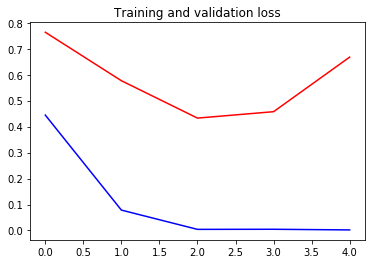

In [62]:
plot_training(InceptionV3_history)

In [88]:
for i, layer in enumerate(InceptionV3_base_model.layers):
    print(i, layer.name)

0 input_6
1 conv2d_471
2 batch_normalization_471
3 activation_471
4 conv2d_472
5 batch_normalization_472
6 activation_472
7 conv2d_473
8 batch_normalization_473
9 activation_473
10 max_pooling2d_21
11 conv2d_474
12 batch_normalization_474
13 activation_474
14 conv2d_475
15 batch_normalization_475
16 activation_475
17 max_pooling2d_22
18 conv2d_479
19 batch_normalization_479
20 activation_479
21 conv2d_477
22 conv2d_480
23 batch_normalization_477
24 batch_normalization_480
25 activation_477
26 activation_480
27 average_pooling2d_46
28 conv2d_476
29 conv2d_478
30 conv2d_481
31 conv2d_482
32 batch_normalization_476
33 batch_normalization_478
34 batch_normalization_481
35 batch_normalization_482
36 activation_476
37 activation_478
38 activation_481
39 activation_482
40 mixed0
41 conv2d_486
42 batch_normalization_486
43 activation_486
44 conv2d_484
45 conv2d_487
46 batch_normalization_484
47 batch_normalization_487
48 activation_484
49 activation_487
50 average_pooling2d_47
51 conv2d_483
52

In [48]:
from keras.models import load_model

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

# submission

In [134]:
test_generator = gen.flow_from_directory("./test", image_size, shuffle=False, batch_size=32,class_mode= "binary")

Found 12500 images belonging to 1 classes.


In [135]:
y_pred = InceptionV3_model.predict_generator(test_generator, verbose=1)

391/391 [==============================] - 175s 449ms/step


In [136]:
y_pred 

array([[0.6747897 ],
       [0.154649  ],
       [0.1293558 ],
       ...,
       [0.23132463],
       [0.14403033],
       [0.1797391 ]], dtype=float32)

In [137]:
y_pred = y_pred.clip(min=0.005, max=0.995)

In [146]:
y_pred 

array([[0.6747897 ],
       [0.154649  ],
       [0.1293558 ],
       ...,
       [0.23132463],
       [0.14403033],
       [0.1797391 ]], dtype=float32)

In [162]:
import pandas as pd
# from keras.preprocessing.image import *

df = pd.read_csv("./sample_submission.csv")

In [164]:
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.loc[index-1,'label'] = y_pred[i][0]

In [166]:
df.to_csv('pred.csv', index=None)

## ypw

In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
image_size=(299,299)
width = image_size[0]
height = image_size[1]
input_tensor = Input((height, width, 3))
x = input_tensor

In [5]:
if lambda_func:
    x = Lambda(lambda_func)(x)

NameError: name 'lambda_func' is not defined

In [8]:
base_model = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [10]:
model = InceptionV3(input_tensor = base_model.input, pooling= GlobalAveragePooling2D()(base_model.output))

96116736/96112376 [==============================] - 1s 0us/step


In [16]:
gen = ImageDataGenerator()
train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                          batch_size=16)
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [17]:
train = model.predict_generator(train_generator, train_generator.nb_sample)

AttributeError: 'DirectoryIterator' object has no attribute 'nb_sample'

In [ ]:
test = model.predict_generator(test_generator, test_generator.nb_sample)

In [ ]:
with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
    h.create_dataset("train", data=train)
    h.create_dataset("test", data=test)
    h.create_dataset("label", data=train_generator.classes)